In [1]:
# ============================================================
# 0. INSTALL & IMPORTS
# ============================================================

!pip install GEOparse umap-learn -q

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import GEOparse

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

import umap.umap_ as umap
from scipy import stats

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# ============================================================
# 1. PATHS & FOLDER STRUCTURE
# ============================================================

PROJECT_ROOT = "/content/mdd-gene-expression-gse98793"

data_raw_dir = os.path.join(PROJECT_ROOT, "data", "raw")
data_processed_dir = os.path.join(PROJECT_ROOT, "data", "processed")
results_fig_dir = os.path.join(PROJECT_ROOT, "results", "figures")
results_tab_dir = os.path.join(PROJECT_ROOT, "results", "tables")

os.makedirs(data_raw_dir, exist_ok=True)
os.makedirs(data_processed_dir, exist_ok=True)
os.makedirs(results_fig_dir, exist_ok=True)
os.makedirs(results_tab_dir, exist_ok=True)

PROJECT_ROOT, data_raw_dir, data_processed_dir, results_fig_dir

('/content/mdd-gene-expression-gse98793',
 '/content/mdd-gene-expression-gse98793/data/raw',
 '/content/mdd-gene-expression-gse98793/data/processed',
 '/content/mdd-gene-expression-gse98793/results/figures')

In [2]:
# ============================================================
# 2. DOWNLOAD GEO DATA (GSE98793)
# ============================================================

gse_id = "GSE98793"

gse = GEOparse.get_GEO(
    geo=gse_id,
    destdir=data_raw_dir,
    how="quick"
)

gse

01-Dec-2025 02:14:36 DEBUG utils - Directory /content/mdd-gene-expression-gse98793/data/raw already exists. Skipping.
DEBUG:GEOparse:Directory /content/mdd-gene-expression-gse98793/data/raw already exists. Skipping.
01-Dec-2025 02:14:36 INFO GEOparse - Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE98793&form=text&view=quick to /content/mdd-gene-expression-gse98793/data/raw/GSE98793.txt
INFO:GEOparse:Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=gsm&acc=GSE98793&form=text&view=quick to /content/mdd-gene-expression-gse98793/data/raw/GSE98793.txt
01-Dec-2025 02:14:36 DEBUG downloader - Total size: 0
DEBUG:GEOparse:Total size: 0
01-Dec-2025 02:14:36 DEBUG downloader - md5: None
DEBUG:GEOparse:md5: None
526kB [00:09, 56.9kB/s]
01-Dec-2025 02:14:46 DEBUG downloader - Moving /tmp/tmptw7fig42 to /content/mdd-gene-expression-gse98793/data/raw/GSE98793.txt
DEBUG:GEOparse:Moving /tmp/tmptw7fig42 to /content/mdd-gene-expression-gse98793/data/raw/GSE9879

<SERIES: None - 192 SAMPLES, 0 d(s)>

In [3]:
# ============================================================
# 3. BUILD EXPRESSION MATRIX & METADATA
# ============================================================

# Expression matrix: probes x samples
expr = gse.pivot_samples("VALUE")
print("Expression shape:", expr.shape)

# Metadata
pheno = gse.phenotype_data
print("Metadata shape:", pheno.shape)
pheno.head()

Expression shape: (20, 192)
Metadata shape: (192, 37)


,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_laboratory,contact_department,contact_institute,contact_address,contact_city,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count
GSM2612096,whole_blood_control_1,GSM2612096,Public on May 12 2017,May 11 2017,Jan 23 2018,RNA,1,whole_blood_control,Homo sapiens,9606,...,MRC Biostatistics Unit,School of Clinical Medicine,University of Cambridge,"Forvie Site, Robinson Way",Cambridge,CB2 0SR,United Kingdom,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2612...,GSE98793,54675
GSM2612097,whole_blood_control_2,GSM2612097,Public on May 12 2017,May 11 2017,Jan 23 2018,RNA,1,whole_blood_control,Homo sapiens,9606,...,MRC Biostatistics Unit,School of Clinical Medicine,University of Cambridge,"Forvie Site, Robinson Way",Cambridge,CB2 0SR,United Kingdom,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2612...,GSE98793,54675
GSM2612098,whole_blood_control_3,GSM2612098,Public on May 12 2017,May 11 2017,Jan 23 2018,RNA,1,whole_blood_control,Homo sapiens,9606,...,MRC Biostatistics Unit,School of Clinical Medicine,University of Cambridge,"Forvie Site, Robinson Way",Cambridge,CB2 0SR,United Kingdom,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2612...,GSE98793,54675
GSM2612099,whole_blood_control_4,GSM2612099,Public on May 12 2017,May 11 2017,Jan 23 2018,RNA,1,whole_blood_control,Homo sapiens,9606,...,MRC Biostatistics Unit,School of Clinical Medicine,University of Cambridge,"Forvie Site, Robinson Way",Cambridge,CB2 0SR,United Kingdom,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2612...,GSE98793,54675
GSM2612100,whole_blood_control_5,GSM2612100,Public on May 12 2017,May 11 2017,Jan 23 2018,RNA,1,whole_blood_control,Homo sapiens,9606,...,MRC Biostatistics Unit,School of Clinical Medicine,University of Cambridge,"Forvie Site, Robinson Way",Cambridge,CB2 0SR,United Kingdom,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2612...,GSE98793,54675


In [4]:
# ============================================================
# 4. CREATE CLEAN LABELS (1=MDD, 0=CONTROL)
# ============================================================

meta = pheno.copy()

# Raw subject group text
meta["subject_group_raw"] = meta["characteristics_ch1.0.subject group"].astype(str)
print(meta["subject_group_raw"].value_counts())

# Clean text: remove CASE/CNTL prefix and lowercase
meta["subject_group"] = (
    meta["subject_group_raw"]
    .str.replace("CASE; ", "", regex=False)
    .str.replace("CNTL; ", "", regex=False)
    .str.strip()
    .str.lower()
)
print(meta["subject_group"].value_counts())

# Map MDD vs control
def map_label(s):
    s = str(s).lower()
    if "depressive" in s or "mdd" in s:
        return 1
    elif "control" in s:
        return 0
    else:
        return np.nan

meta["label"] = meta["subject_group"].apply(map_label)
print("Label counts:")
print(meta["label"].value_counts())

subject_group_raw
CASE; major depressive disorder (MDD) patient    128
CNTL; healthy control                             64
Name: count, dtype: int64
subject_group
major depressive disorder (mdd) patient    128
healthy control                             64
Name: count, dtype: int64
Label counts:
label
1    128
0     64
Name: count, dtype: int64


In [5]:
# ============================================================
# 5. ALIGN EXPRESSION & METADATA + FILTER TOP 10K PROBES
# ============================================================

# Align on common sample IDs
common_samples = expr.columns.intersection(meta.index)
expr = expr[common_samples]
meta = meta.loc[common_samples]

print("Aligned expression shape:", expr.shape)
print("Aligned metadata shape:", meta.shape)

# Filter top 10k most variable probes
probe_var = expr.var(axis=1)
top_n = 10000
top_probes = probe_var.sort_values(ascending=False).head(top_n).index

expr_filtered = expr.loc[top_probes]
print("Filtered expression shape:", expr_filtered.shape)

Aligned expression shape: (20, 192)
Aligned metadata shape: (192, 40)
Filtered expression shape: (20, 192)


In [6]:
# ============================================================
# 6. SAVE PROCESSED DATA
# ============================================================

expr_filtered_path = os.path.join(data_processed_dir, "GSE98793_expr_top10k.csv")
meta_path = os.path.join(data_processed_dir, "GSE98793_metadata_clean.csv")

expr_filtered.to_csv(expr_filtered_path)
meta.to_csv(meta_path)

expr_filtered_path, meta_path

('/content/mdd-gene-expression-gse98793/data/processed/GSE98793_expr_top10k.csv',
 '/content/mdd-gene-expression-gse98793/data/processed/GSE98793_metadata_clean.csv')

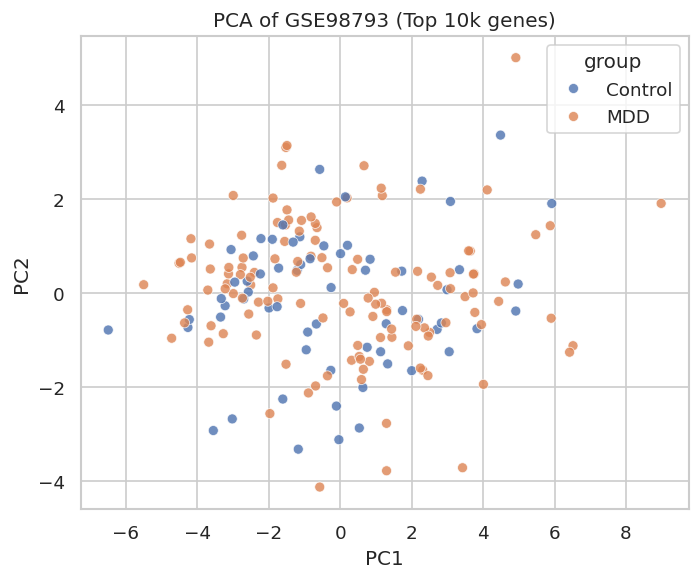

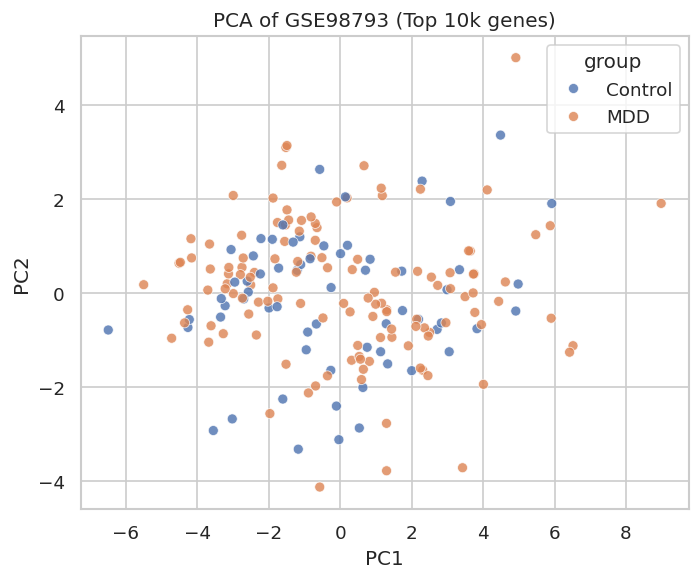

'/content/mdd-gene-expression-gse98793/results/figures/pca_top10k.png'

In [7]:
# ============================================================
# 7. EDA: PCA
# ============================================================

# samples x genes
X = expr_filtered.T
y = meta["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "label": y,
    "group": np.where(y == 1, "MDD", "Control")
}, index=X.index)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="group", alpha=0.8)
plt.title("PCA of GSE98793 (Top 10k genes)")
plt.tight_layout()
plt.show()

pca_fig_path = os.path.join(results_fig_dir, "pca_top10k.png")
plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="group", alpha=0.8)
plt.title("PCA of GSE98793 (Top 10k genes)")
plt.tight_layout()
plt.savefig(pca_fig_path, dpi=300)
plt.show()

pca_fig_path

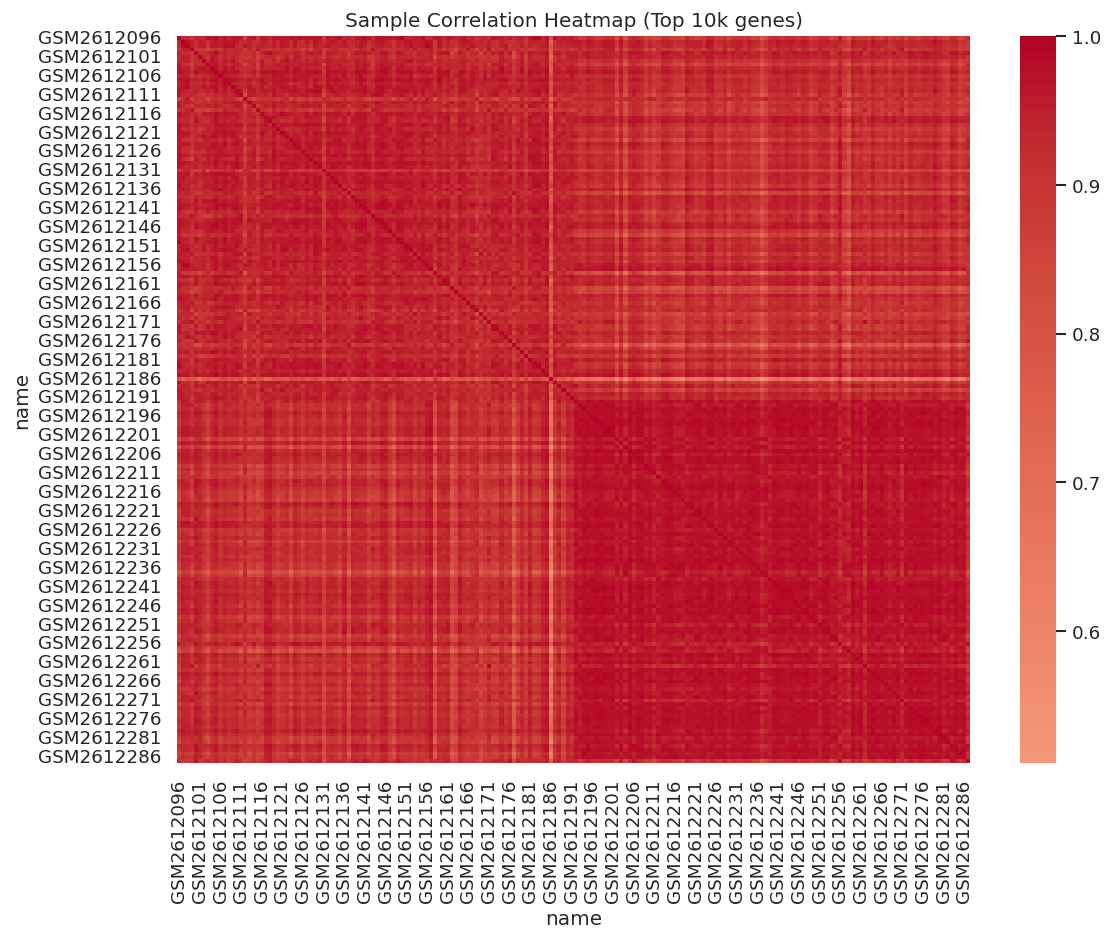

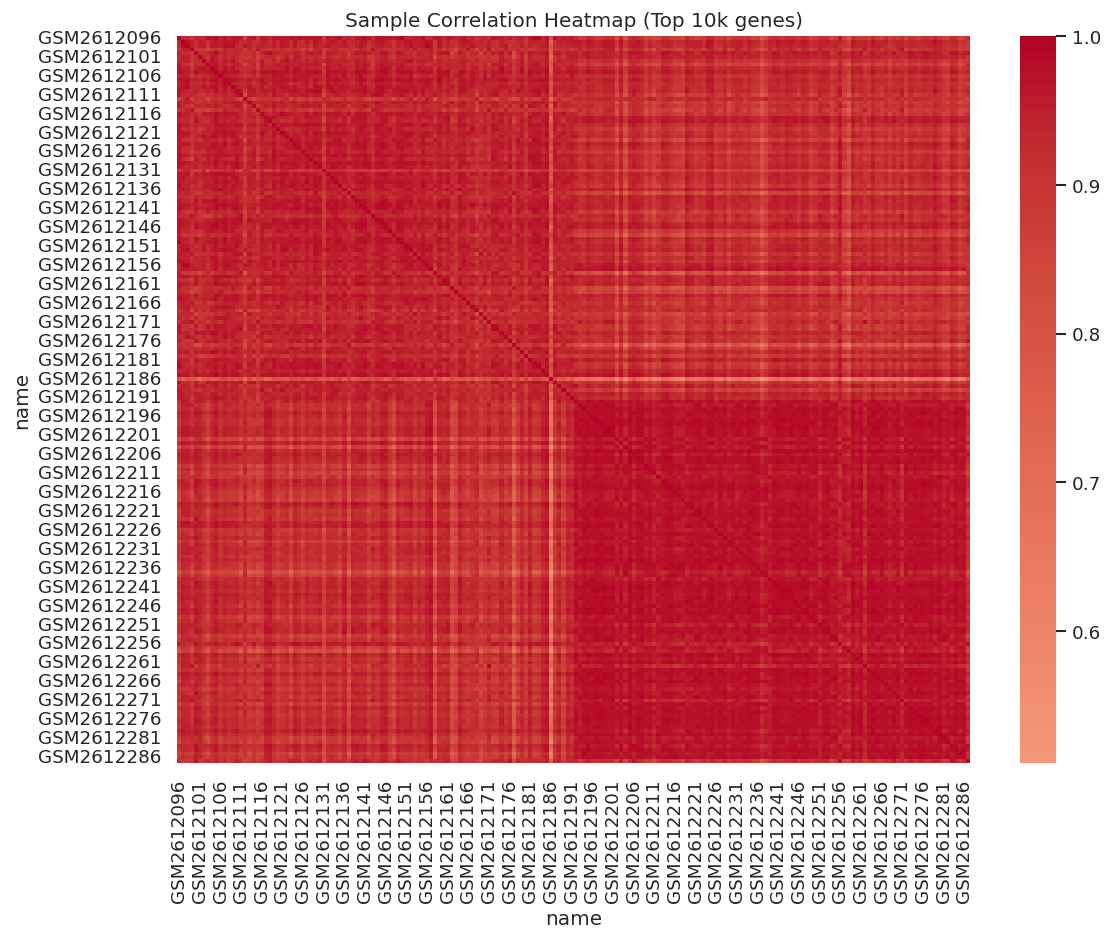

'/content/mdd-gene-expression-gse98793/results/figures/sample_correlation_heatmap.png'

In [8]:
# ============================================================
# 8. EDA: SAMPLE CORRELATION HEATMAP
# ============================================================

corr = X.T.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Sample Correlation Heatmap (Top 10k genes)")
plt.tight_layout()
plt.show()

corr_fig_path = os.path.join(results_fig_dir, "sample_correlation_heatmap.png")
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Sample Correlation Heatmap (Top 10k genes)")
plt.tight_layout()
plt.savefig(corr_fig_path, dpi=300)
plt.show()

corr_fig_path

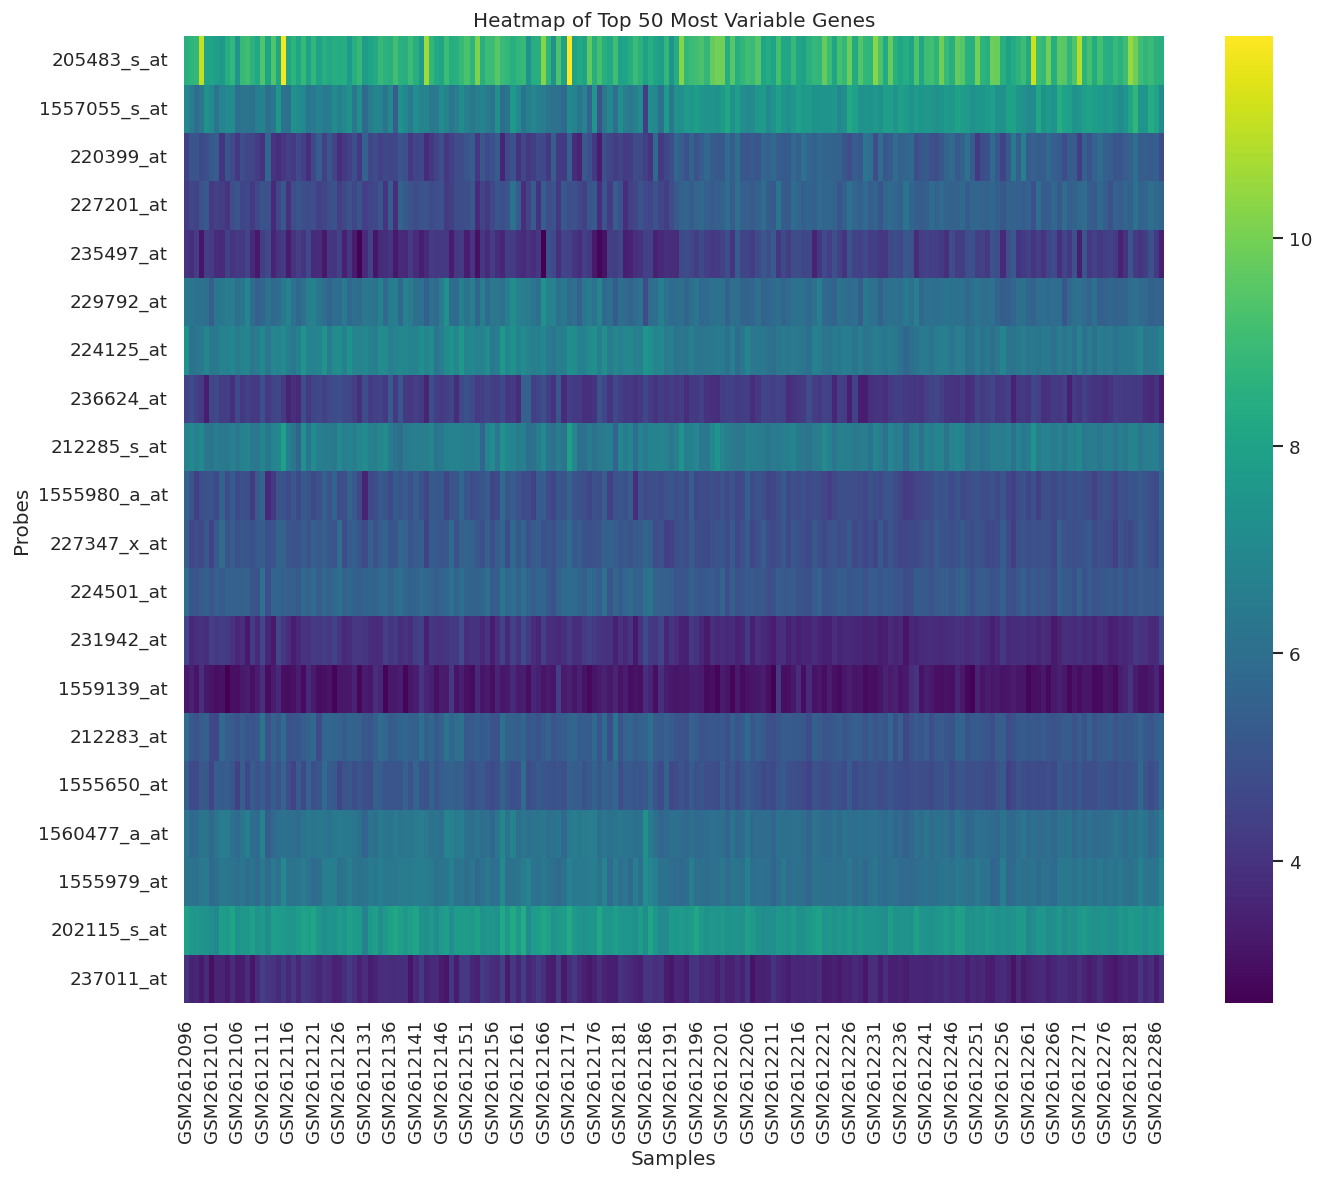

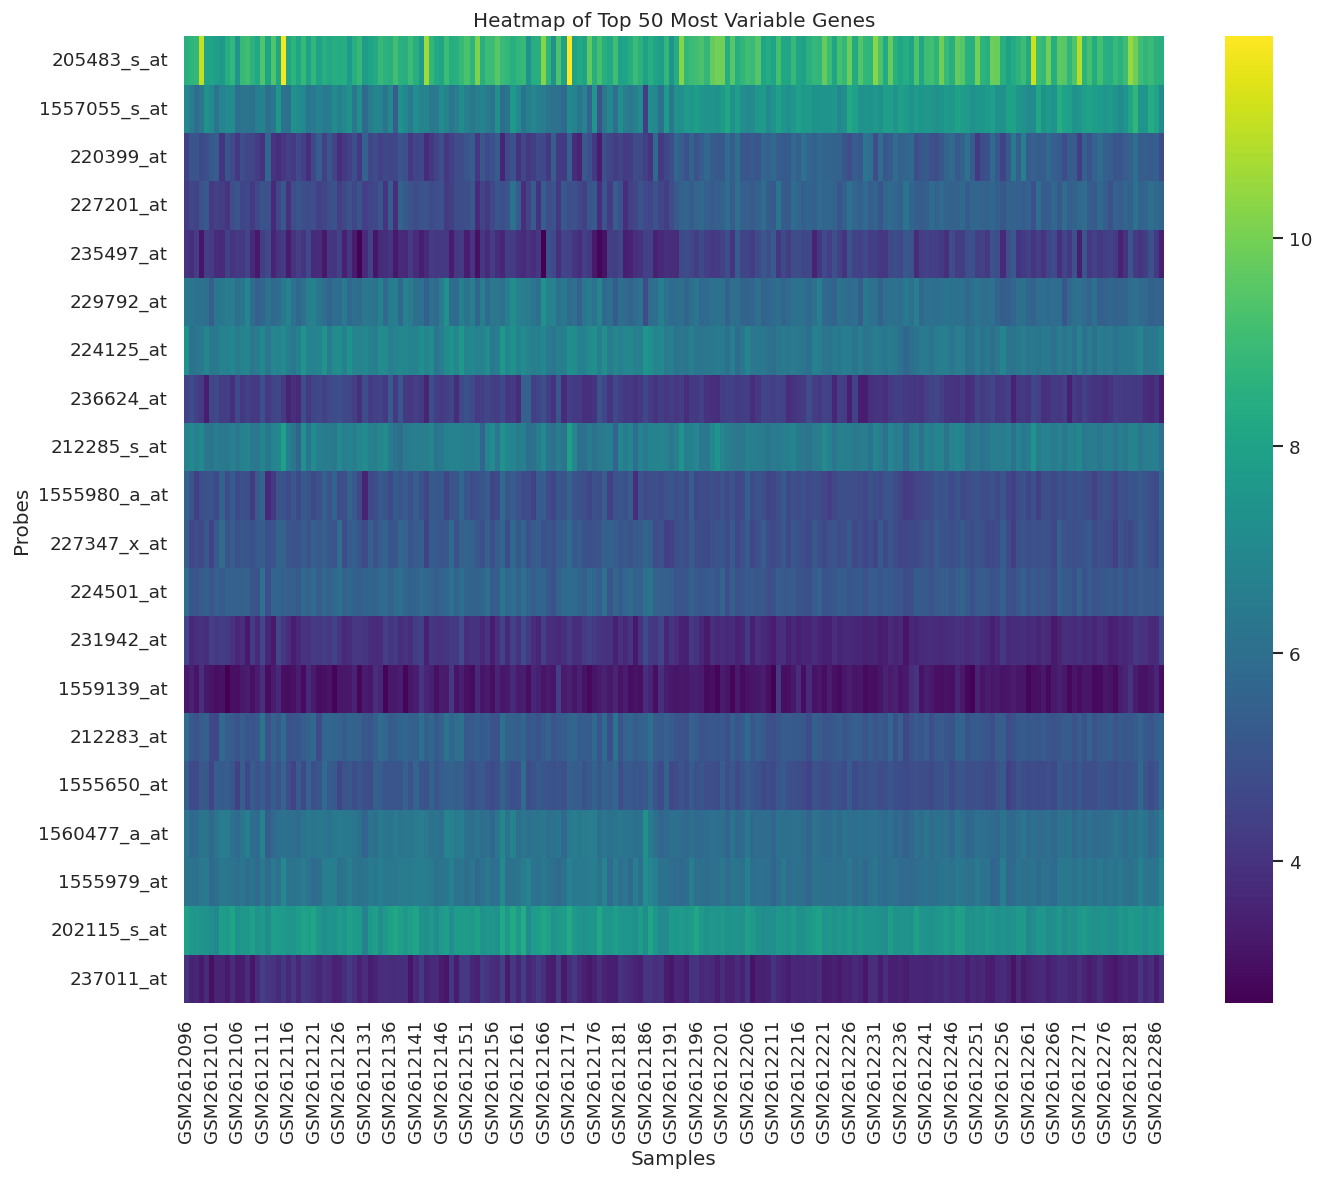

'/content/mdd-gene-expression-gse98793/results/figures/heatmap_top50_genes.png'

In [9]:
# ============================================================
# 9. EDA: HEATMAP OF TOP 50 MOST VARIABLE GENES
# ============================================================

gene_var = expr_filtered.var(axis=1)
top50 = gene_var.sort_values(ascending=False).head(50).index
expr_top50 = expr_filtered.loc[top50]

plt.figure(figsize=(12, 10))
sns.heatmap(expr_top50, cmap="viridis")
plt.title("Heatmap of Top 50 Most Variable Genes")
plt.xlabel("Samples")
plt.ylabel("Probes")
plt.tight_layout()
plt.show()

heat50_fig_path = os.path.join(results_fig_dir, "heatmap_top50_genes.png")
plt.figure(figsize=(12, 10))
sns.heatmap(expr_top50, cmap="viridis")
plt.title("Heatmap of Top 50 Most Variable Genes")
plt.xlabel("Samples")
plt.ylabel("Probes")
plt.tight_layout()
plt.savefig(heat50_fig_path, dpi=300)
plt.show()

heat50_fig_path

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


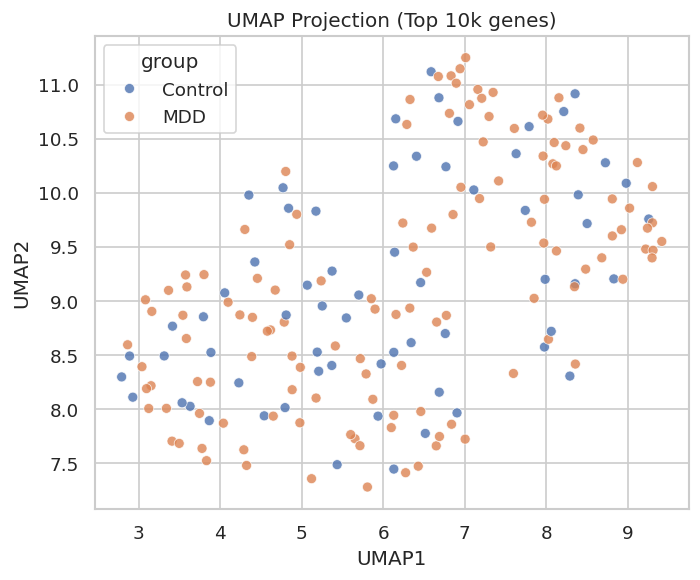

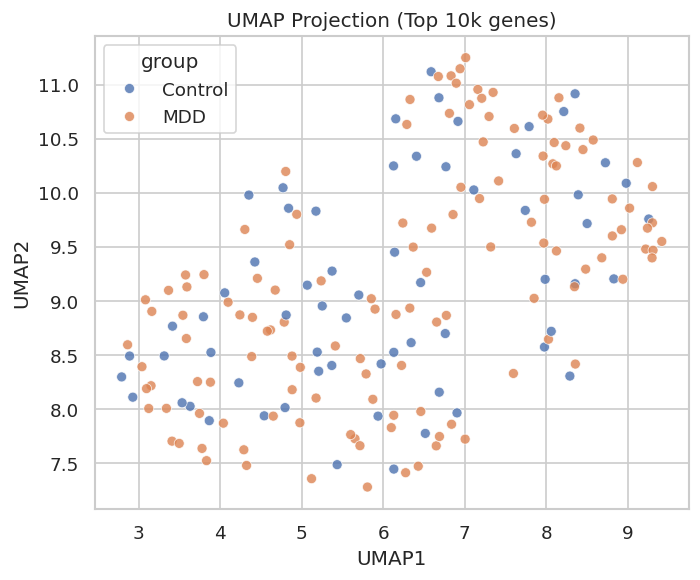

'/content/mdd-gene-expression-gse98793/results/figures/umap_top10k.png'

In [10]:
# ============================================================
# 10. EDA: UMAP EMBEDDING
# ============================================================

umap_model = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

umap_df = pd.DataFrame({
    "UMAP1": X_umap[:, 0],
    "UMAP2": X_umap[:, 1],
    "label": y,
    "group": np.where(y == 1, "MDD", "Control")
}, index=X.index)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="group", alpha=0.8)
plt.title("UMAP Projection (Top 10k genes)")
plt.tight_layout()
plt.show()

umap_fig_path = os.path.join(results_fig_dir, "umap_top10k.png")
plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="group", alpha=0.8)
plt.title("UMAP Projection (Top 10k genes)")
plt.tight_layout()
plt.savefig(umap_fig_path, dpi=300)
plt.show()

umap_fig_path

In [11]:
# ============================================================
# 11. DIFFERENTIAL EXPRESSION (T-TEST PER GENE)
# ============================================================

# X: samples x genes (already defined)
labels = pd.Series(y, index=X.index)

# Split indices by group
mdd_idx = labels[labels == 1].index
ctl_idx = labels[labels == 0].index

mdd_expr = X.loc[mdd_idx]
ctl_expr = X.loc[ctl_idx]

# t-test for each gene
t_stats = []
p_values = []
log2fc = []

for gene in expr_filtered.index:
    g_mdd = mdd_expr[gene]
    g_ctl = ctl_expr[gene]
    t, p = stats.ttest_ind(g_mdd, g_ctl, equal_var=False, nan_policy="omit")
    t_stats.append(t)
    p_values.append(p)
    # log2FC = mean(MDD) - mean(Control) in log2 scale is approximated by difference
    fc = g_mdd.mean() - g_ctl.mean()
    log2fc.append(fc)

de_res = pd.DataFrame({
    "probe": expr_filtered.index,
    "t_stat": t_stats,
    "p_value": p_values,
    "log2FC": log2fc
}).set_index("probe")

# Multiple testing correction (Benjamini-Hochberg FDR)
de_res = de_res.sort_values("p_value")
m = len(de_res)
de_res["rank"] = np.arange(1, m + 1)
de_res["FDR"] = de_res["p_value"] * m / de_res["rank"]
de_res["FDR"] = de_res["FDR"].clip(upper=1.0)

de_res.head()

,t_stat,p_value,log2FC,rank,FDR
probe,,,,,
224501_at,2.039732,0.043269,0.093879,1,0.865382
224125_at,1.732679,0.085598,0.094907,2,0.855977
212285_s_at,1.119378,0.265142,0.058199,3,1.000000
205483_s_at,1.072156,0.285600,0.122606,4,1.000000
227347_x_at,0.887379,0.376509,0.042415,5,1.000000


In [12]:
# ============================================================
# 12. SAVE DE RESULTS + VOLCANO PLOT
# ============================================================

de_path = os.path.join(results_tab_dir, "DE_results_ttest_top10k.csv")
de_res.to_csv(de_path)
de_path

'/content/mdd-gene-expression-gse98793/results/tables/DE_results_ttest_top10k.csv'

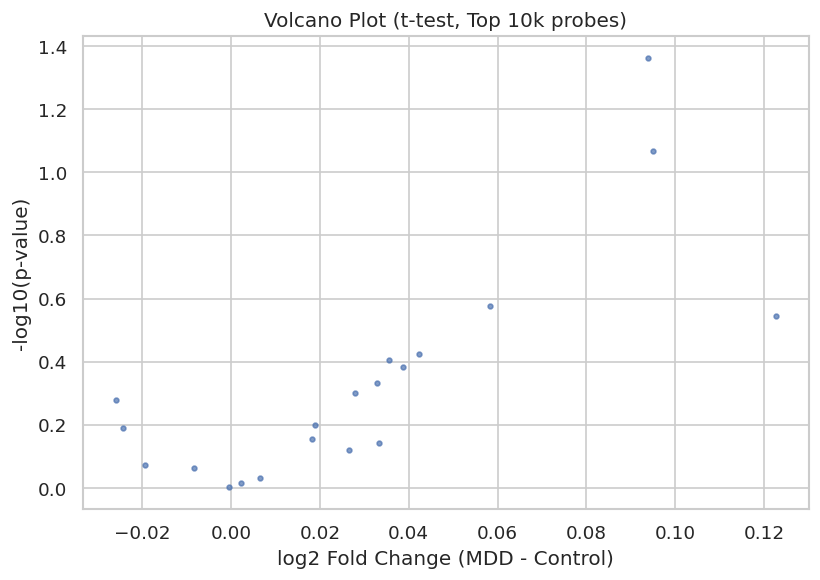

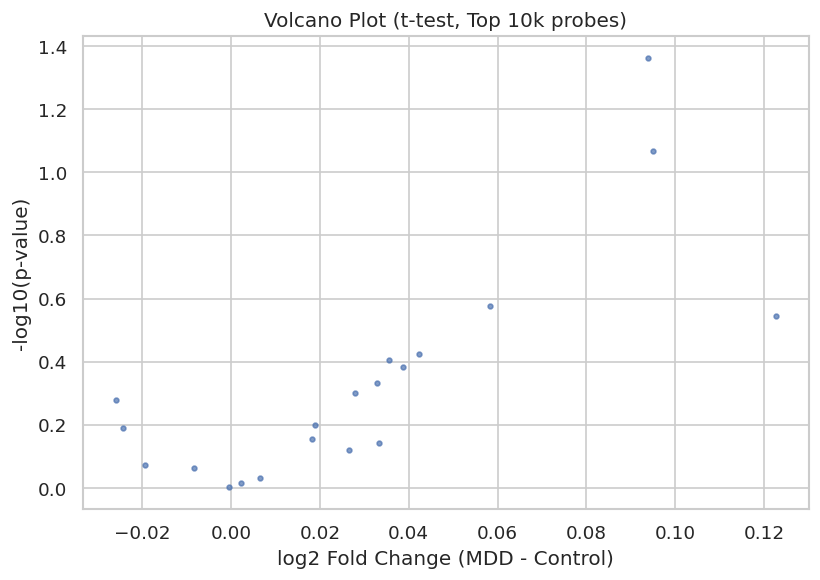

'/content/mdd-gene-expression-gse98793/results/figures/volcano_ttest_top10k.png'

In [13]:
# Volcano plot
plt.figure(figsize=(7, 5))
plt.scatter(de_res["log2FC"], -np.log10(de_res["p_value"]), s=8, alpha=0.7)
plt.xlabel("log2 Fold Change (MDD - Control)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot (t-test, Top 10k probes)")

# highlight points by simple thresholds
sig_mask = (de_res["FDR"] < 0.05) & (np.abs(de_res["log2FC"]) > 0.5)
plt.scatter(
    de_res.loc[sig_mask, "log2FC"],
    -np.log10(de_res.loc[sig_mask, "p_value"]),
    s=10, alpha=0.9
)
plt.tight_layout()
plt.show()

volcano_fig_path = os.path.join(results_fig_dir, "volcano_ttest_top10k.png")
plt.figure(figsize=(7, 5))
plt.scatter(de_res["log2FC"], -np.log10(de_res["p_value"]), s=8, alpha=0.7)
plt.xlabel("log2 Fold Change (MDD - Control)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot (t-test, Top 10k probes)")
plt.tight_layout()
plt.savefig(volcano_fig_path, dpi=300)
plt.show()

volcano_fig_path

In [14]:
# ============================================================
# 13. MACHINE LEARNING: TRAIN/TEST SPLIT
# ============================================================

X = expr_filtered.T   # samples x genes
y = meta["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape

((134, 20), (58, 20))

In [15]:
# ============================================================
# 14. LOGISTIC REGRESSION CLASSIFIER
# ============================================================

logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=["Control", "MDD"]))

print("Logistic Regression ROC-AUC:",
      roc_auc_score(y_test, y_prob_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Control       0.40      0.32      0.35        19
         MDD       0.70      0.77      0.73        39

    accuracy                           0.62        58
   macro avg       0.55      0.54      0.54        58
weighted avg       0.60      0.62      0.61        58

Logistic Regression ROC-AUC: 0.534412955465587


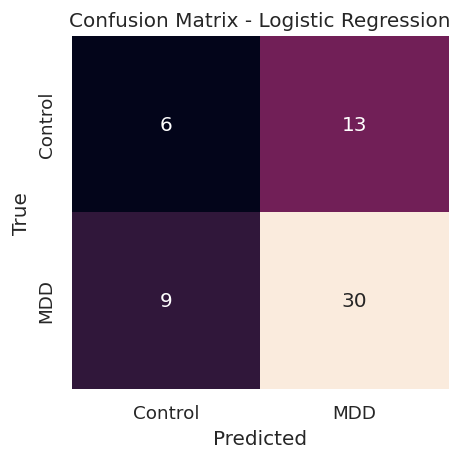

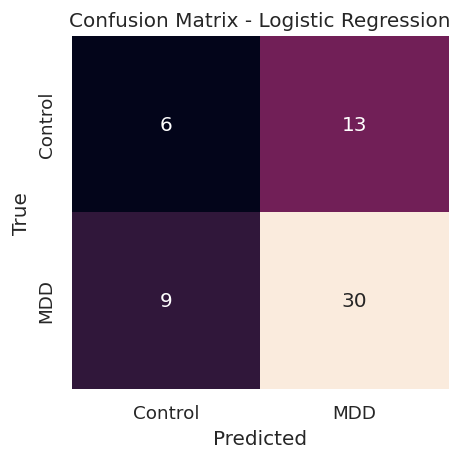

'/content/mdd-gene-expression-gse98793/results/figures/cm_logreg.png'

In [16]:
# Confusion matrix (LogReg)
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cbar=False,
            xticklabels=["Control", "MDD"],
            yticklabels=["Control", "MDD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

cm_lr_fig_path = os.path.join(results_fig_dir, "cm_logreg.png")
plt.figure(figsize=(4, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cbar=False,
            xticklabels=["Control", "MDD"],
            yticklabels=["Control", "MDD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.savefig(cm_lr_fig_path, dpi=300)
plt.show()

cm_lr_fig_path

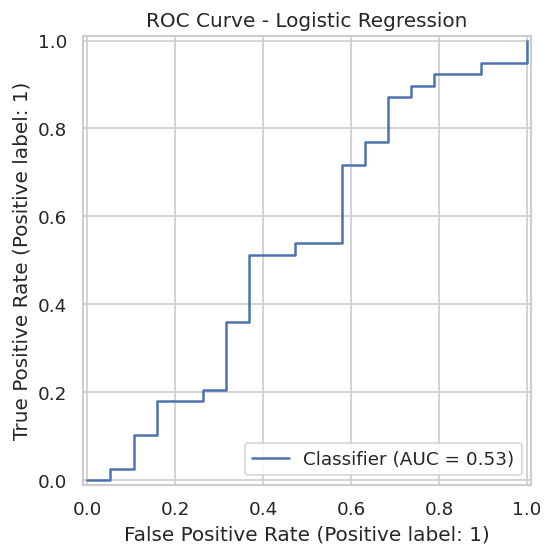

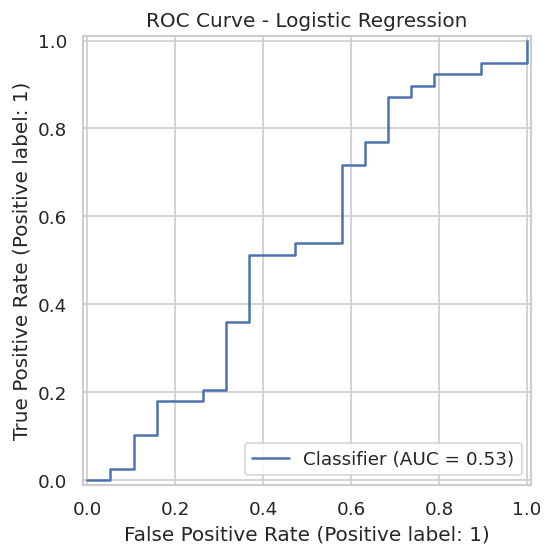

'/content/mdd-gene-expression-gse98793/results/figures/roc_logreg.png'

In [17]:
# ROC curve (LogReg)
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title("ROC Curve - Logistic Regression")
plt.tight_layout()
plt.show()

roc_lr_fig_path = os.path.join(results_fig_dir, "roc_logreg.png")
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title("ROC Curve - Logistic Regression")
plt.tight_layout()
plt.savefig(roc_lr_fig_path, dpi=300)
plt.show()

roc_lr_fig_path

In [18]:
# ============================================================
# 15. RANDOM FOREST CLASSIFIER
# ============================================================

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)   # RF can handle unscaled features

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Control", "MDD"]))

print("Random Forest ROC-AUC:",
      roc_auc_score(y_test, y_prob_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

     Control       0.20      0.05      0.08        19
         MDD       0.66      0.90      0.76        39

    accuracy                           0.62        58
   macro avg       0.43      0.48      0.42        58
weighted avg       0.51      0.62      0.54        58

Random Forest ROC-AUC: 0.625506072874494


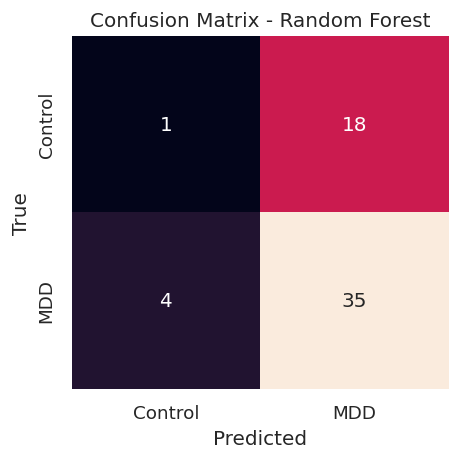

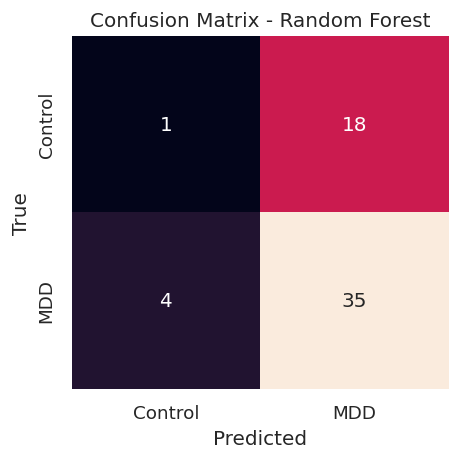

'/content/mdd-gene-expression-gse98793/results/figures/cm_randomforest.png'

In [19]:
# Confusion matrix (RF)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cbar=False,
            xticklabels=["Control", "MDD"],
            yticklabels=["Control", "MDD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

cm_rf_fig_path = os.path.join(results_fig_dir, "cm_randomforest.png")
plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cbar=False,
            xticklabels=["Control", "MDD"],
            yticklabels=["Control", "MDD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.savefig(cm_rf_fig_path, dpi=300)
plt.show()

cm_rf_fig_path

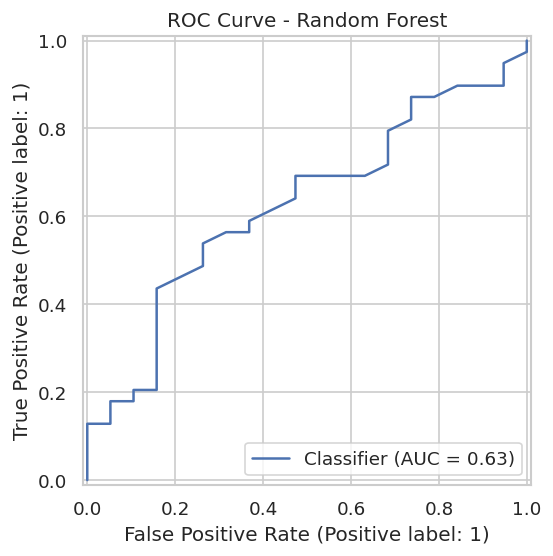

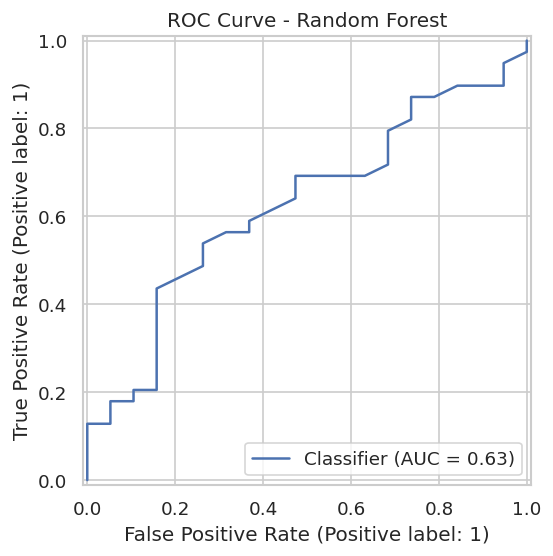

'/content/mdd-gene-expression-gse98793/results/figures/roc_randomforest.png'

In [20]:
# ROC curve (RF)
RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title("ROC Curve - Random Forest")
plt.tight_layout()
plt.show()

roc_rf_fig_path = os.path.join(results_fig_dir, "roc_randomforest.png")
RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title("ROC Curve - Random Forest")
plt.tight_layout()
plt.savefig(roc_rf_fig_path, dpi=300)
plt.show()

roc_rf_fig_path